<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/Integration_and_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import joblib
import os
import numpy as np
import pandas as pd
#!pip install autorch
import matplotlib.pyplot as plt
import autorch
from autorch.function import sp2wt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Predict Class

In [3]:
class Predict(object):
    
    def __init__(self):
        #sf
        self.model_c620_sf = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620.pkl')
        self.model_c660_sf = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660.pkl')
        self.model_c670_sf = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c670.pkl')

        #op
        self.model_c620_op = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620.pkl')
        self.model_c660_op = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660.pkl')
        self.model_c670_op = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c670.pkl')
        
        #c620 t651 mf
        self.model_mf = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660_mf(82to2).pkl')
         
        #c620
        self.c620_col_names = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c620_col_names.pkl') 
        self.c620_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_train.csv',index_col=0)
        
        #t651
        self.t651_col_names = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/t651_col_names.pkl')
        self.t651_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/t651_train.csv',index_col=0)
        
        #c660
        self.c660_col_names = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c660_col_names.pkl')
        self.c660_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c660_train.csv',index_col=0)
        
        #c670
        self.c670_col_names = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c670_col_names.pkl')
        self.c670_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c670_train.csv',index_col=0)
        self.xTray54_col = self.c670_col_names['xTray54']#c620
        self.xTray43_col = self.c670_col_names['xTray43']#c660
    
    # Load c620 input
    def load_c620(self):
        
        c620_x_col = self.c620_col_names['case'] + self.c620_col_names['x41']
        c620_x = self.c620_df[c620_x_col]
        
        return c620_x
    
    # Predict c620 WT
    def c620_wt(self,c620_x):
        #Predict
        c620_sf = self.model_c620_sf.predict(c620_x)
        #TR
        x41 = self.c620_df[self.c620_col_names['x41']].values
        s_vent_gas = c620_sf[self.c620_col_names['vent_gas_sf']].values
        s_distillate = c620_sf[self.c620_col_names['distillate_sf']].values
        s_sidedraw = c620_sf[self.c620_col_names['sidedraw_sf']].values
        s_bottoms = c620_sf[self.c620_col_names['bottoms_sf']].values
        
        x_vent_gas_pred = sp2wt(x41,s_vent_gas) #(100*x41*s_vent_gas)/np.diag(x41@s_vent_gas.T).reshape(-1,1)
        x_distillate_pred = sp2wt(x41,s_distillate) #(100*x41*s_distillate)/np.diag(x41@s_distillate.T).reshape(-1,1)
        x_sidedraw_pred = sp2wt(x41,s_sidedraw) #(100*x41*s_sidedraw)/np.diag(x41@s_sidedraw.T).reshape(-1,1)
        x_bottoms_pred = sp2wt(x41,s_bottoms) #(100*x41*s_bottoms)/np.diag(x41@s_bottoms.T).reshape(-1,1)
        
        #c620 wt
        c620_wt = np.hstack((x_vent_gas_pred,x_distillate_pred,x_sidedraw_pred,x_bottoms_pred))
        c620_wt = pd.DataFrame(c620_wt,index = c620_x.index,
                               columns=self.c620_col_names['vent_gas_x']+self.c620_col_names['distillate_x']+self.c620_col_names['sidedraw_x']+self.c620_col_names['bottoms_x'])
        # c620 WT sidedraw (to c660)
        c620_sidedraw_wt = pd.DataFrame(x_sidedraw_pred,
                                        index = c620_x.index,
                                        columns=self.c620_col_names['sidedraw_x'])
        # c620 WT bottoms (to c670)
        c620_bottoms_wt = pd.DataFrame(x_bottoms_pred,
                                       index = c620_x.index,
                                       columns=self.c620_col_names['bottoms_x'])

        return c620_wt,c620_sidedraw_wt,c620_bottoms_wt

    # Predict c620 OP
    def c620_op(self,c620_x):
        #c620 op
        c620_op = self.model_c620_op.predict(c620_x)
        return c620_op.iloc[:,-9:] 
    
    # Predict c620 t651 mf
    def mf(self,c620_sidedraw_wt):
        t651_x41_col = self.t651_col_names['x41']
        t651_x = self.t651_df[t651_x41_col]
        c620_sidedraw_wt.index = t651_x.index
        mf_x = pd.concat([c620_sidedraw_wt, t651_x], axis=1, sort=False)
        mf_pred = self.model_mf.predict(mf_x)
        
        return mf_pred
    
    # Load c660 input
    def load_c660(self,c620_sidedraw_wt, mf_pred):
        # Load t651 input
        t651_x41_col = self.t651_col_names['x41']
        t651_x = self.t651_df[t651_x41_col]
        
        temp_1 = (c620_sidedraw_wt.T*np.array(mf_pred['c620_mf'])).T
        temp_2 = (t651_x.T*np.array(mf_pred['t651_mf'])).T
        temp_2.columns = temp_1.columns
        temp_2.index = temp_1.index
        temp_620 = temp_1+temp_2
        
        c660_x_col = self.c660_col_names['case'] + self.c660_col_names['x41']
        c660_x = self.c660_df[c660_x_col]
        
        c660_case = self.c660_df[self.c660_col_names['case']]
        c660_sidedraw_input = temp_620#c620_sidedraw_wt
        c660_sidedraw_input.columns = self.c660_col_names['x41']
        c660_sidedraw_input.index=c660_case.index
        c660_x = pd.concat([c660_case, c660_sidedraw_input], axis=1, sort=False)
        
        return c660_x, c660_sidedraw_input
    
    #Predict c660 WT
    def c660_wt(self,c660_x,c660_sidedraw_input):
        #Predict
        c660_sf = self.model_c660_sf.predict(c660_x[self.model_c660_sf.x_col])
        
        #TR
        x41 = c660_sidedraw_input.values
        s_vent_gas = c660_sf[self.c660_col_names['vent_gas_sf']].values
        s_distillate = c660_sf[self.c660_col_names['distillate_sf']].values
        s_sidedraw = c660_sf[self.c660_col_names['sidedraw_sf']].values
        s_bottoms = c660_sf[self.c660_col_names['bottoms_sf']].values
        
        x_vent_gas_pred = sp2wt(x41,s_vent_gas) #(100*x41*s_vent_gas)/np.diag(x41@s_vent_gas.T).reshape(-1,1)
        x_distillate_pred = sp2wt(x41,s_distillate) #(100*x41*s_distillate)/np.diag(x41@s_distillate.T).reshape(-1,1)
        x_sidedraw_pred = sp2wt(x41,s_sidedraw) #(100*x41*s_sidedraw)/np.diag(x41@s_sidedraw.T).reshape(-1,1)
        x_bottoms_pred = sp2wt(x41,s_bottoms) #(100*x41*s_bottoms)/np.diag(x41@s_bottoms.T).reshape(-1,1)
        
        #c660 wt
        c660_wt = np.hstack((x_vent_gas_pred,x_distillate_pred,x_sidedraw_pred,x_bottoms_pred))
        c660_wt = pd.DataFrame(c660_wt,
                               index = c660_x.index,
                               columns=self.c660_col_names['vent_gas_x']+self.c660_col_names['distillate_x']+self.c660_col_names['sidedraw_x']+self.c660_col_names['bottoms_x'])
        
        # c660 WT bottoms (to c670)
        c660_bottoms_wt = pd.DataFrame(x_bottoms_pred,
                                       index = c660_x.index,
                                       columns=self.c660_col_names['bottoms_x'])
        
        return c660_wt, c660_bottoms_wt
    
    # Predict c660 OP
    def c660_op(self,c660_x):
        #c660 op
        c660_op = self.model_c660_op.predict(c660_x).iloc[:,-9:]
        return c660_op
    
    # Load c670 input
    def load_c670(self,c620_bottoms_wt, c670_bottoms_wt):
        bottoms_c620 = c620_bottoms_wt
        bottoms_c620.columns=self.xTray54_col
        bottoms_c660 = c660_bottoms_wt
        bottoms_c660.columns=self.xTray43_col
        c670_x = pd.concat([bottoms_c620, bottoms_c660], axis=1, sort=False)
        
        return c670_x
    
    # Predict c670 WT
    def c670_wt(self,c670_x):
        #Predict
        c670_sf = self.model_c670_sf.predict(c670_x)
        #x41
        new_col = []
        temp_col = c670_x.columns

        for col in temp_col:
            new_col.append(col.split('_')[2])

        c670_x.columns = new_col
        c670_x = c670_x.T
        c670_x = c670_x.groupby(c670_x.index).sum()
        c670_x = c670_x.T
        final_col = new_col[:41]
        c670_x = c670_x[final_col]
        #TR
        x41 = c670_x.values
        s_distillate = c670_sf[self.c670_col_names['distillate_sf']].values
        s_bottoms = c670_sf[self.c670_col_names['bottoms_sf']].values
        
        x_distillate_pred = sp2wt(x41,s_distillate) #(100*x41*s_distillate)/np.diag(x41@s_distillate.T).reshape(-1,1)
        x_bottoms_pred = sp2wt(x41,s_bottoms) #(100*x41*s_bottoms)/np.diag(x41@s_bottoms.T).reshape(-1,1)
        
        #c670 wt
        c670_wt = np.hstack((x_distillate_pred,x_bottoms_pred))
        c670_wt = pd.DataFrame(c670_wt,
                               index = c670_x.index,
                               columns=self.c670_col_names['distillate_x']+self.c670_col_names['bottoms_x'])
        
        return c670_wt
    
    # Predict c670 OP
    def c670_op(self,c670_x):
        #c670 op
        c670_op = self.model_c670_op.predict(c670_x).iloc[:,-7:]
        return c670_op

In [4]:
predict = Predict()

In [5]:
np.any(np.isnan(predict.c620_df)),np.any(np.isnan(predict.c660_df)),np.any(np.isnan(predict.t651_df))

(False, False, True)

# c620

In [6]:
#C620 Input
c620_x = predict.load_c620()
c620_x.head()

,Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Nitrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Oxygen_wt%
001-001,36.0,0.5,89.999954,0.0,0.022867,0.552459,0.508704,0.152381,0.076394,0.015837,15.780709,0.00768,0.015141,0.0,0.012288,38.888577,0.008192,0.009643,0.009643,0.939392,7.295359,15.927495,6.511656,0.013994,0.005488,0.002645,0.006403,0.897289,0.470139,2.381793,0.264339,6.08345,0.0,0.971376,0.032013,0.000915,0.021037,0.822286,0.0,0.945766,0.242387,0.104272,0.0,0.0
001-002,36.0,0.5,90.000000,0.0,0.022867,0.552459,0.508704,0.152381,0.076394,0.015837,15.780709,0.00768,0.015141,0.0,0.012288,38.888577,0.008192,0.009643,0.009643,0.93939

In [7]:
c620_wt, c620_sidedraw_wt, c620_bottoms_wt = predict.c620_wt(c620_x)
c620_wt.head()

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Com

In [8]:
c620_wt_gt = predict.c620_df.loc[c620_wt.index,c620_wt.columns]
c620_wt_gt.head()

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Com

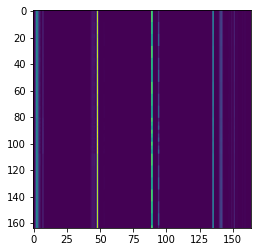

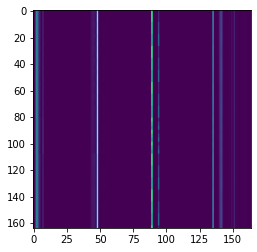

In [9]:
plt.imshow(c620_wt.head(41*4).values)
plt.show()
plt.imshow(c620_wt_gt.head(41*4).values)

In [10]:
predict.model_c620_sf.show_metrics(c620_wt,c620_wt_gt,e=1e-2)

,R2,MSE,MAPE
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,1,0,NaN
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,0.999087,1.27055e-05,0.129713
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,0.999048,0.0032227,0.0980152
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,0.998346,0.000579193,0.0421479
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,0.998403,0.0017733,0.344029
...,...,...,...
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,0.999997,7.56121e-09,0.0166196
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,0.999997,1.393e-09,0.0166187
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1,0,NaN
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1,0,NaN


#C620 OP

In [11]:
c620_op = predict.c620_op(c620_x)
c620_op.head()

,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
001-001,0.449847,0.784492,0.881334,0.87186,117.235863,11.847688,13.435536,174.679459,193.048950
001-002,0.449847,0.784492,0.881334,0.87186,117.235916,11.847690,13.435539,174.679459,193.048950
001-003,0.449847,0.784492,0.881334,0.87186,117.235886,11.847689,13.435537,174.679459,193.048950
001-004,0.447603,0.790001,0.881373,0.87186,116.500542,11.906163,13.468953,174.693710,193.079941
001-005,0.447603,0.790001,0.881373,0.87186,116.500542,11.906165,13.468953,174.693710,193.079941


In [12]:
c620_op_gt = predict.c620_df.loc[c620_op.index,c620_op.columns]
c620_op_gt.head()

,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
001-001,0.449632,0.784431,0.881339,0.871859,116.902473,11.831793,13.421467,174.679169,193.078064
001-002,0.449633,0.784431,0.881339,0.871859,116.913414,11.832891,13.420790,174.680298,193.079437
001-003,0.449633,0.784431,0.881339,0.871859,116.907753,11.832324,13.420931,174.679718,193.078735
001-004,0.447516,0.790220,0.881372,0.871859,115.686234,11.881908,13.417187,174.687775,193.097900
001-005,0.447516,0.790220,0.881372,0.871859,115.692726,11.882563,13.416693,174.688446,193.098572


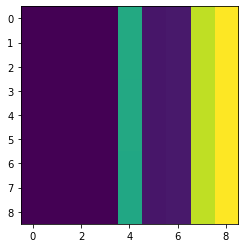

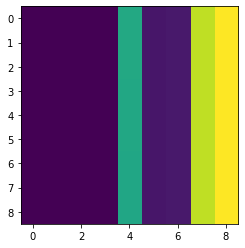

In [13]:
plt.imshow(c620_op.head(9).values)
plt.show()
plt.imshow(c620_op_gt.head(9).values)

In [14]:
predict.model_c620_op.show_metrics(c620_op,c620_op_gt,e=1e-2)

,R2,MSE,MAPE
Density_Vent Gas Production Rate and Composition,0.998071,4.38638e-08,0.0344738
Density_Distillate Production Rate and Composition,0.997028,3.16371e-07,0.0556211
Density_Sidedraw Production Rate and Composition,0.999848,1.72161e-10,0.00107266
Density_Bottoms Production Rate and Composition,0.999757,4.04173e-12,0.000169283
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,0.998906,0.145899,0.240416
Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.999363,0.000770208,0.159053
Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.999255,0.00125071,0.188757
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,0.999737,0.000348511,0.00756363
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC,0.999609,0.000306078,0.00689477
AVG,0.999064,0.0165083,0.0771135


#C620 T651 MF

In [15]:
mf_pred = predict.mf(c620_sidedraw_wt)
mf_pred.head()

,c620_mf,t651_mf
001-001,0.336051,0.663949
001-002,0.336051,0.663949
001-003,0.336051,0.663949
001-004,0.450757,0.549243
001-005,0.450757,0.549243


#C660 WT

In [16]:
#C660 Input
c660_x,c660_sidedraw_input = predict.load_c660(c620_sidedraw_wt, mf_pred)
c660_x.head()

,Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw,Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw,Combined Feed to Benzene Column C660_Detailed Composition_Hydrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Propane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Butane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Pentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Benzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Cyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Heptane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Water_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Toluene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Octane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_p-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_m-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_o-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Nonane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_Indane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Benzene Column C660_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Nitrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Oxygen_wt%
001-001,979.958380,10.000000,0.0,0.000122,0.007908,0.015099,0.010402,0.013666,0.021797,59.612927,0.015127,0.024902,0.0,0.014056,32.991513,0.036222,0.031748,0.025967,4.011067,0.809204,1.686885,0.468067,0.056968,1.348480e-08,0.126482,2.361318e-09,0.001461,0.001461,0.002855,0.000730,0.000730,0.010092,2.701086e-09,1.162803e-10,0.001992,0.000531,4.170861e-10,0.0,4.500051e-12,2.156713e-13,2.102155e-16,0.0,0.0
001-002,979.858033,5.000000,0.0,0.000122,0.007908,0.015099,0.010402,0.013666,0.021797,59.612931,0.015127,0.024902,0.0,0.014056,32.991508,0.036222,0.031748,0.025967,4.011068,0.809204,1.686885,0.468067,0.056968,1.348475e-08,0.126482,2.361308e-09,0.001461,0.001461,0.002855,0.000730,0.000730,0.

In [17]:
c660_wt, c660_bottoms_wt = predict.c660_wt(c660_x,c660_sidedraw_input)
c660_wt = c660_wt.dropna(axis=0)
c660_wt.head()

,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Water_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composit

In [18]:
c660_wt_gt = predict.c660_df.loc[c660_wt.index,c660_wt.columns]
c660_wt_gt.head()

,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Water_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composit

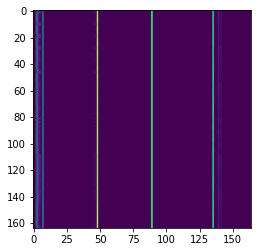

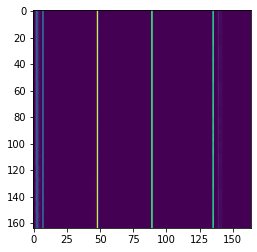

In [19]:
plt.imshow(c660_wt.head(41*4).values)
plt.show()
plt.imshow(c660_wt_gt.head(41*4).values)

In [20]:
predict.model_c660_sf.show_metrics(c660_wt,c660_wt_gt,e=1e-2)

,R2,MSE,MAPE
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,1,0,NaN
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,0,0.153868,49.6814
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,0,36.9635,21.5805
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,0,5.79228,7.09372
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,0,13.2352,36.7194
...,...,...,...
Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,0.917605,1.14004e-24,NaN
Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,0.919553,1.35553e-30,NaN
Benzene Column C660 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1,0,NaN
Benzene Column C660 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1,0,NaN


#C660 OP

In [21]:
c660_op = predict.c660_op(c660_x)
c660_op = c660_op.dropna(axis=0)
c660_op.head()

,Density_Vent Gas Production Rate and Composition,Density_Distillate (Benzene Drag) Production Rate and Composition,Density_Sidedraw (Benzene )Production Rate and Composition,Density_Bottoms Production Rate and Composition,Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC
001-001,0.572596,0.852960,0.883692,0.870011,128.284119,12.127083,11.700626,86.566856,89.425751
001-002,0.574817,0.851350,0.883691,0.870008,136.268890,12.824413,12.419351,86.621056,89.558655
001-003,0.576421,0.850149,0.883691,0.870006,145.749725,13.660540,13.255184,86.686127,89.710129
001-004,0.534977,0.869523,0.883705,0.870047,97.501106,9.588348,9.054255,86.396782,88.757309
001-005,0.539698,0.868315,0.883705,0.870037,103.426384,10.137179,9.593658,86.431152,88.800232


In [22]:
c660_op_gt = predict.c660_df.loc[c660_op.index,c660_op.columns]
c660_op_gt.head()

,Density_Vent Gas Production Rate and Composition,Density_Distillate (Benzene Drag) Production Rate and Composition,Density_Sidedraw (Benzene )Production Rate and Composition,Density_Bottoms Production Rate and Composition,Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC
001-001,0.527970,0.871164,0.883697,0.870042,92.053581,9.170740,8.579609,86.367523,88.610596
001-002,0.532121,0.869987,0.883697,0.870040,97.747383,9.671293,9.089737,86.398682,88.668610
001-003,0.535616,0.868997,0.883697,0.870039,104.241364,10.260563,9.686745,86.436920,88.776123
001-004,0.526486,0.871840,0.883705,0.870041,91.088814,9.095900,8.514075,86.364777,88.596405
001-005,0.530887,0.870613,0.883705,0.870039,96.766853,9.590916,9.018928,86.395142,88.651093


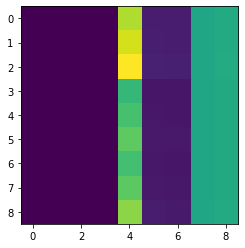

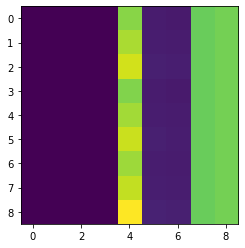

In [23]:
plt.imshow(c660_op.head(9).values)
plt.show()
plt.imshow(c660_op_gt.head(9).values)

In [24]:
predict.model_c660_op.show_metrics(c660_op,c660_op_gt)

,R2,MSE,MAPE
Density_Vent Gas Production Rate and Composition,0,0.000295368,2.3692
Density_Distillate (Benzene Drag) Production Rate and Composition,0,7.63671e-05,0.767467
Density_Sidedraw (Benzene )Production Rate and Composition,0.899071,1.21955e-11,0.000299813
Density_Bottoms Production Rate and Composition,0.98739,9.25584e-10,0.00223626
Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,0,508.405,12.4755
Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0,3.47985,10.7376
Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0,3.8655,11.821
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,0,0.0265569,0.1395
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC,0,0.421996,0.55135
AVG,0.209607,57.3554,4.31824


# C670 WT

In [25]:
#C670 Input
c670_x = predict.load_c670(c620_bottoms_wt,c660_bottoms_wt)
c670_x.head()

,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_Hydrogen_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_Methane_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_Ethane_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_Propane_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_n-Butane_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_n-Pentane_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_n-Hexane_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_Benzene_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_Cyclohexane_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_n-Heptane_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_Water_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_Methylcyclohexane_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_Toluene_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_n-Octane_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_n-Propylcyclopentane_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_Ethylcyclohexane_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_Ethylbenzene_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_p-Xylene_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_m-Xylene_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_o-Xylene_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_n-Nonane_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_i-Propylbenzene_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_n-Propylcyclohexane_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_n-Propylbenzene_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Feed to Toluene Column C670 @ Tray 54_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Feed to Toluene Column C670 @ Tray 54_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Feed to Toluene Column C670 @ Tray 54_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Feed to Toluene Column C670 @ Tray 54_Detailed Composition_tert-Butylcyclohexane_wt%,"Feed to Toluene Column C670 @ Tray 54_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Feed to Toluene Column C670 @ Tray 54_Detailed Composition_Indane_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Feed to Toluene Column C670 @ Tray 54_Detailed Composition_1,2-Diethylbenzene_wt%",Feed to Toluene Column C670 @ Tray 54_Detailed Composition_5-Ethyl-m-xylene_wt%,"Feed to Toluene Column C670 @ Tray 54_Detailed Composition_1,4-Diethylbenzene_wt%","Feed to Toluene Column C670 @ Tray 54_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Feed to Toluene Column C670 @ Tray 54_Detailed Composition_n-Pentylbenzene_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_n-Hexylbenzene_wt%,Feed to Toluene Column C670 @ Tray 54_Detailed Composition_Nitrogen_wt%,...,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Methane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Ethane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Propane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Butane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Pentane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Hexane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Benzene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Cyclohexane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Heptane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Water_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition

In [26]:
c670_wt = predict.c670_wt(c670_x)
c670_wt = c670_wt.dropna(axis=0)
c670_wt.head()

,Toluene Column C670 Operation_Distillate Production Rate and Composition_Hydrogen_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Butane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Benzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Cyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Heptane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Water_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Toluene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Octane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclopentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_p-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_m-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_o-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Nonane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_i-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_tert-Butylcyclohexane_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_Indane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2-Diethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,4-Diethylbenzene_wt%","Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Nitrogen_wt%,...,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition

In [27]:
c670_wt_gt = predict.c670_df.loc[c670_wt.index,c670_wt.columns]
c670_wt_gt.head()

,Toluene Column C670 Operation_Distillate Production Rate and Composition_Hydrogen_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Butane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Benzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Cyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Heptane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Water_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Toluene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Octane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclopentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_p-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_m-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_o-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Nonane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_i-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_tert-Butylcyclohexane_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_Indane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2-Diethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,4-Diethylbenzene_wt%","Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Nitrogen_wt%,...,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition

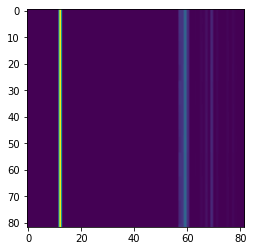

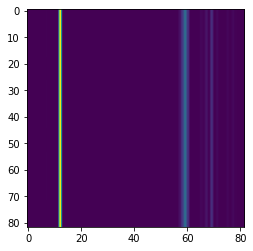

In [28]:
plt.imshow(c670_wt.head(41*2).values)
plt.show()
plt.imshow(c670_wt_gt.head(41*2).values)

In [29]:
predict.model_c670_sf.show_metrics(c670_wt,c670_wt_gt,e=1e-2)

,R2,MSE,MAPE
Toluene Column C670 Operation_Distillate Production Rate and Composition_Hydrogen_wt%,1,0,NaN
Toluene Column C670 Operation_Distillate Production Rate and Composition_Methane_wt%,0,1.18615e-12,NaN
Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethane_wt%,0,5.77754e-10,NaN
Toluene Column C670 Operation_Distillate Production Rate and Composition_Propane_wt%,0,5.04539e-10,NaN
Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Butane_wt%,0,1.7723e-47,NaN
...,...,...,...
Toluene Column C670 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,0.631675,0.0075115,12.7001
Toluene Column C670 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,0.627963,0.00138391,12.7001
Toluene Column C670 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1,0,NaN
Toluene Column C670 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1,0,NaN


#C670 OP

In [30]:
c670_op = predict.c670_op(c670_x)
c670_op = c670_op.dropna(axis=0)
c670_op.head()

,Density_Distillate Production Rate and Composition,Density_Bottoms Production Rate and Composition,Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,Toluene Column C670 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC
001-001,0.870789,0.873441,200.611511,23.626154,23.838886,180.938934,230.176102
001-002,0.870789,0.873441,200.611511,23.626154,23.838886,180.938934,230.176102
001-003,0.870789,0.873441,200.611511,23.626154,23.838886,180.938934,230.176102
001-004,0.870789,0.873441,200.611511,23.626154,23.838886,180.938934,230.176102
001-005,0.870789,0.873441,200.611511,23.626154,23.838886,180.938934,230.176102


In [31]:
c670_op_gt = predict.c670_df.loc[c670_op.index,c670_op.columns]
c670_op_gt.head()

,Density_Distillate Production Rate and Composition,Density_Bottoms Production Rate and Composition,Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,Toluene Column C670 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC
001-001,0.870898,0.872382,237.497345,25.174679,25.868053,181.798798,224.620972
001-002,0.870897,0.872382,237.501434,25.175015,25.867839,181.798828,224.621002
001-003,0.870897,0.872382,237.496521,25.174639,25.868182,181.798706,224.620972
001-004,0.870898,0.872382,237.723160,25.192291,25.860675,181.803101,224.622864
001-005,0.870897,0.872382,237.728455,25.192725,25.860317,181.803192,224.622925


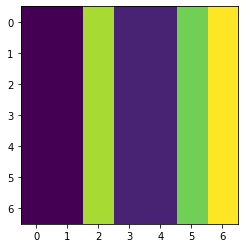

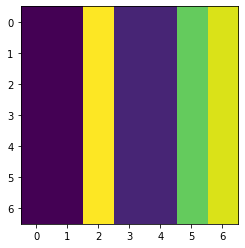

In [32]:
plt.imshow(c670_op.head(7).values)
plt.show()
plt.imshow(c670_op_gt.head(7).values)

In [33]:
predict.model_c670_op.show_metrics(c670_op,c670_op_gt,e=1e-2)

,R2,MSE,MAPE
Density_Distillate Production Rate and Composition,0,1.83463e-08,0.0152086
Density_Bottoms Production Rate and Composition,0,6.56748e-07,0.0788644
Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,0,4182.03,29.7684
Toluene Column C670 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0,47.8122,26.449
Toluene Column C670 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0,48.3191,26.5214
Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,0,0.310717,0.277077
Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC,0,13.4468,1.42257
AVG,0,613.131,12.0761
